
ERT modeling and inversion in 2D
================================



Import necessary dependencies. <br/> pyGIMLi (www.pygimli.org) and PyBERT (https://pypi.org/project/PyBERT/) are used to create mesh, perform forward modeling and inversion.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {    return false;}

<IPython.core.display.Javascript object>

In [3]:
import warnings
warnings.filterwarnings('ignore') # just to make it cleaner in the notebook
import numpy as np
import pybert as pb
import pygimli as pg
import pygimli.meshtools as mt  # save space
import pandas as pd
import copy
import matplotlib
%matplotlib notebook
from matplotlib import pyplot as plt

Read the data file with apparent res from TIGRE <br/> Define the nr. of electrodes. <br/> Get the electrode spacing and the total number of measurements of $\rho_a$ <br/> Organise data in a numpy array

In [4]:
tigre_file="tigre_20_01_2020.dat"
# read header info :
with open(tigre_file, "r") as filin:
    headr=filin.read().splitlines()[0:6]
Nread=float(headr[3])
dx=float(headr[1])
filin.close()
# read data until end of file and strip the ending zeroes:
readings=[];
with open(tigre_file, "r") as filin:
    dada=filin.read().splitlines()[6:-1]
for line in dada:
    if line.strip("\n") != "0":
        readings.append(line.split())
filin.close()
readings=np.array(readings,dtype=np.float32)
first_spacing=readings[0,1]
Nel=2
for ri in readings:
    Nel=Nel+1 # Count Number of electrodes
    if ri[1] != first_spacing:
        break
#
#display(pd.DataFrame(headr))
print("tot readings: ",Nread,"|| el. spacing dx= ",dx,"|| nr. of electrodes= ",Nel)

tot readings:  650.0 || el. spacing dx=  5.0 || nr. of electrodes=  64


In [5]:
# prepare sequence of electrode positions, PYBERT-unified style:
elpos=[]
for i in range(Nel):
    elpos.append([dx*i, 0, 0])  
# Add synthetic topography:
elpos=np.asarray(elpos)
for i in range(Nel):elpos[i,2]=elpos[i,2]+10.*np.exp(-i*dx/20.)

In [6]:
# Convert Wenner mid-point of 4x and "a" value to index of electrodes in array.
# Organise resistivity and corresponding electrode indexes, PYBERT-unified style, in array abmnr:
abmnr=[]
for ree in readings:
    p1=int(round((ree[0]-ree[1]/2.)/dx))+1
    p2=int(round((ree[0]+ree[1]/2.)/dx))+1
    c1=int(round((ree[0]-3*ree[1]/2.)/dx))+1
    c2=int(round((ree[0]+3*ree[1]/2.)/dx))+1
    abmnr.append([c1,c2,p1,p2,ree[2]])

In [7]:
# Put all together in one file in PYBERT-unified format:
filout=tigre_file[:-4]+"_uni2"+".dat" # name of output file
file_object = open(filout, 'w')
file_object.write(str(Nel)+"\n") # write nr. of electrodes in array
file_object.write("# x y z \n")  # write comment line 
for val in elpos:  # write x, y, z pos for each electrode:
    file_object.write(str(val[0])+"\t"+ str(val[1])+"\t"+ str(val[2])+"\n")
file_object.write(str(int(Nread))+"\n") # write total nr. of readings
file_object.write('# a b m n err rhoa \n')  # comment line
for val in abmnr:  # write index of current electrodes (a,b), potential electrodes (m,n), and app.resistivity (r) 
    lin=str(val[0])+"\t"+str(val[1])+\
    "\t"+str(val[2])+"\t"+str(val[3])+\
    "\t"+str(0.1)+"\t"+str(val[4]) # add by default an error of0.1
    file_object.write(lin+"\n")
file_object.write(str(0)) # append zero to signal end of data file
print('file reforamtted and saved as ',filout)
# Close the file
file_object.close()

file reforamtted and saved as  tigre_20_01_2020_uni2.dat


In [8]:
# read-in the reformatted data file:
data=pb.importer.importData('tigre_20_01_2020_uni2.dat');

14/10/20 - 18:24:12 - pyGIMLi - INFO - imported:  Data: Electrodes: 64 data: 650


In [9]:
# Start the ERTManager to invert the modeled data. We call it ert:
ert = pb.ERTManager()

14/10/20 - 18:24:15 - pyGIMLi - WARNING - Module ps psutil not found.


In [10]:
import time
start_time = time.time()
print('starting inversion.... THIS MAY TAKE A FEW MINUTES...')
time.sleep(0.1)
#model = ert.invert(data, paraDX=10., maxCellArea=10.,lam=20)
model = ert.invert(data,lam=200,paraDX=100.0)
print('total cpu time for inversion : ',time.time()-start_time)

starting inversion.... THIS MAY TAKE A FEW MINUTES...
creating mesh...
Mesh: Nodes: 917 Cells: 1664 Boundaries: 2580
Mesh: Nodes: 917 Cells: 1664 Boundaries: 2580
total cpu time for inversion :  15.615030527114868


14/10/20 - 18:24:36 - pyGIMLi - INFO - Saving resistivity data to: .///ERTManager/


<IPython.core.display.Javascript object>


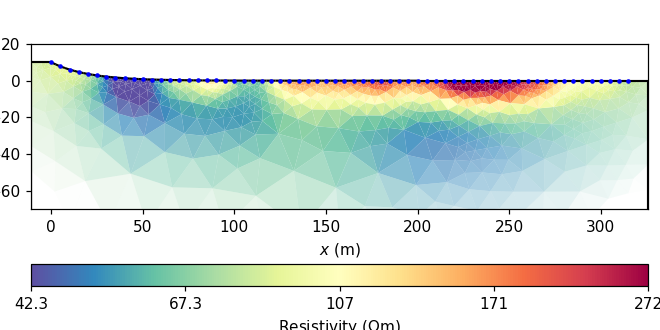

In [11]:
import os
#ert.showResult(cMap='Spectral_r')
os.system("rm -rf ./OLD")
os.system("mv ./ERTManager ./OLD");
ert.saveResult("./",cMap='Spectral_r');
fig=plt.gcf()
fig.axes[0].plot(elpos[:,0],elpos[:,2],'bo',ms=2)
fig.axes[0].set(ylim=(-70.0, 20.0))
fig.set_size_inches(6,3);

In [49]:
fig.savefig('houghall2020_res.pdf')

## Show error / misfit

<IPython.core.display.Javascript object>


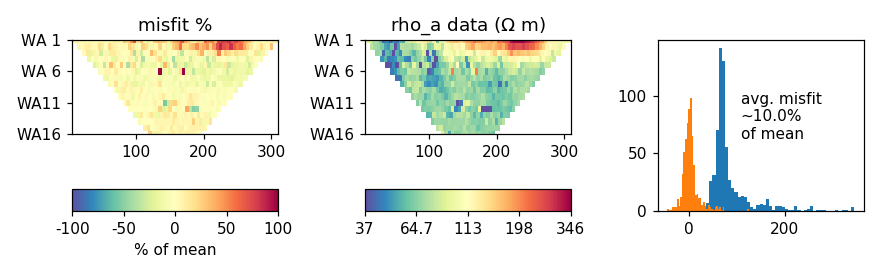

In [14]:
resp=ert.inv.response(); #retrieve the response from the inverted model
diff=np.asarray(readings[:,2])-np.asarray(resp); # compute difference with original data
fig,ax=plt.subplots(1,3,figsize=(8,2.5));
me=round(np.mean(diff),1);
mea=np.mean(np.abs(diff));
mava=max(readings[:,2]);miva=min(readings[:,2]);
miva=37;
#
sd=round(np.std(diff),1);
me2=round(np.mean(readings[:,2]),1);
sd2=round(np.std(readings[:,2]),1);
perc=np.round((mea/me2),1)*100.
sd2=round(np.std(readings[:,2]),1);
#
ert.showData(100*diff/me2,ax=ax[0],cMin=-100,cMax=100,cMap='Spectral_r',label='% of mean');
ert.showData(readings[:,2],ax=ax[1],cMin=miva,cMax=mava,cMap='Spectral_r');

ax[0].set_title("misfit %")
ax[1].set_title("rho_a data ($\Omega$ m)")
ax[2].hist(readings[:,2],bins=50);
ax[2].hist(diff,bins=50);
ax[2].text(me2+sd2/2,max(diff)/2,"avg. misfit\n~"+str(perc)+"%\n"+"of mean")

fig.tight_layout()

## Extract cell vertexes, compute cell centroids, and plot

In [15]:
from linecache import getline
# find first and last line of vertexes, extract them to an array:
with open('./ERTManager/resistivity.vtk') as f:
    for ind, line in enumerate(f,1):
        if "POINTS" in line: l1=ind
        if "CELLS" in line:  l2=ind
        if "CELL_TYPES" in line: l3=ind
        if "SCALARS Resistivity double" in line: l4=ind+1 
print(getline(f.name, l1))
print(getline(f.name, l2))
print(getline(f.name, l3))
print(getline(f.name, l4))
f.close()
verts  = pd.read_table('./ERTManager/resistivity.vtk',sep="\t",skiprows=l1,header=None,nrows=l2-l1-1)
verts  = np.asarray(verts,dtype=float)
groups = pd.read_table('./ERTManager/resistivity.vtk',sep="\t",skiprows=l2,header=None,nrows=l3-l2-1)
groups = np.asarray(groups,dtype=int)[:,1:4]
resis  = pd.read_table('./ERTManager/resistivity.vtk',sep=" ",skiprows=l4,header=None,nrows=1)
resis  = np.asarray(resis,dtype=float)[:,:-1].flatten()

POINTS 686 double

CELLS 1204 4816

CELL_TYPES 1204

LOOKUP_TABLE default



In [16]:
xc=[];yc=[];tritri=[];
for gri in groups:
    xc.append((1/3)*(verts[gri[0]][0] + verts[gri[1]][0] + verts[gri[2]][0]))
    yc.append((1/3)*(verts[gri[0]][1] + verts[gri[1]][1] + verts[gri[2]][1]))
xc=np.asarray(xc);yc=np.asarray(yc);

In [23]:
in2= ert.coverageDC(); 
in2=(-min(in2)+in2/(max(in2)-min(in2)))
xx=verts[:,0];yy=verts[:,1];tritri=[];
rere=np.zeros(len(xx));count=np.zeros(len(xx));cover=np.zeros(len(xx))
for ig, gri in enumerate(groups):
    tritri.append(gri)
    for iv, ve in enumerate(gri):
        count[ve]=count[ve]+1
        rere[ve]=rere[ve]+resis[ig]
        cover[ve]=cover[ve]+in2[ig]
for ve in range(len(xx)):
    rere[ve]=rere[ve]/count[ve]
    cover[ve]=cover[ve]/count[ve]
tritri=np.asarray(tritri);rere=np.asarray(rere);cover=np.asarray(cover)

<IPython.core.display.Javascript object>


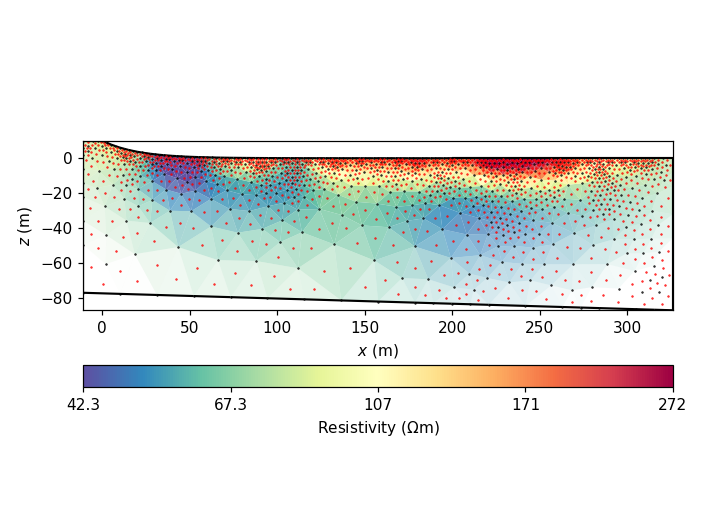

14/10/20 - 18:45:46 - pyGIMLi - WARNING - Keyword argument name changed from 'cmap' to 'cMap'


In [20]:
ert.showResult(cmap='Spectral_r');
fig=plt.gcf()
fig.axes[0].plot(verts[:,0],verts[:,1],'ko',markersize=1/2);
fig.axes[0].plot(xc,yc,'ro',markersize=1/2);
#fig.set_size_inches(6,3);

<IPython.core.display.Javascript object>


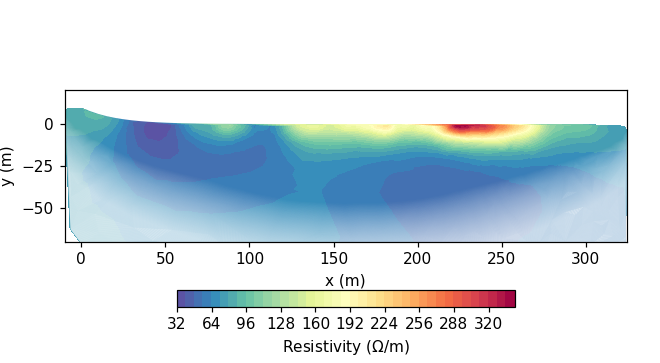

In [22]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import matplotlib.colors as colors
import matplotlib.tri as mtri
import matplotlib.cm as cm
cm.register_cmap(name='alphaGradient',data={'red':   [(0,1,1), (1.,1,1)],'green': [(0.,1,1), (1.,1.,1.)],
                       'blue':  [(0.,1,1), (1.,1.,1.)],'alpha': [(0.,1,1),  (1.,0,0)]})
triang = tri.Triangulation(xc, yc)

fig1, ax1 = plt.subplots(figsize=(6,3.3))
ax1.set_aspect('equal')
colo='Spectral_r'
cof=ax1.tricontourf(triang,resis,50,alpha=1,vmin=min(resis),
                    vmax=max(resis),cmap=colo)
caf=ax1.tricontourf(triang,in2,800,cmap='alphaGradient',
                    vmin=min(in2)+.2,vmax=max(in2)-.6)
ax1.fill(elpos[:,0],elpos[:,2],'w')
#caf=ax1.contourf(xi, yi, zi_lin,cmap='alphaGradient',vmin=min(in2),vmax=max(in2))
fig1.colorbar(cof, ax=ax1, shrink=0.6, orientation='horizontal', label='Resistivity ($\Omega$/m)')
for c in caf.collections:
    c.set_edgecolor('face')
    c.set_linewidth(1e-6)
ax1.set_xlabel('x (m)');ax1.set_ylabel('y (m)')
ax1.set_ylim(-70,20)
fig1.tight_layout(pad=0.0, rect=[0.0,0.0,.95,0.95])
#ax1.set_ylim(-50,14)
#ax1.plot(xc,yc,'ro',markersize=1)